In [0]:
!pip3 install pyensembl
!pyensembl install --release 99 --species mus_musculus


2020-05-17 18:18:15,286 - pyensembl.shell - INFO - Running 'install' for EnsemblRelease(release=99, species='mus_musculus')
2020-05-17 18:18:16,280 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from /root/.cache/pyensembl/GRCm38/ensembl99/Mus_musculus.GRCm38.cdna.all.fa.gz.pickle
2020-05-17 18:18:16,332 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from /root/.cache/pyensembl/GRCm38/ensembl99/Mus_musculus.GRCm38.ncrna.fa.gz.pickle
2020-05-17 18:18:16,432 - pyensembl.sequence_data - INFO - Loaded sequence dictionary from /root/.cache/pyensembl/GRCm38/ensembl99/Mus_musculus.GRCm38.pep.all.fa.gz.pickle


In [0]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pyensembl import EnsemblRelease

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataFilePath = "/content/drive/My Drive/ScRNA_data/GSE109262_ESC_RNA_counts.txt"
# dataFilePath = "./data/GSE109262_ESC_RNA_counts.txt_processed.tsv"

In [0]:
df = pd.read_csv(dataFilePath,sep='\t')

In [0]:
df.head(20)

,ESC_ens_id,ESC_A01,ESC_A02,ESC_A03,ESC_A04,ESC_A05,ESC_A06,ESC_A07,ESC_A08,ESC_A09,ESC_A10,ESC_B01,ESC_B02,ESC_B03,ESC_B04,ESC_B05,ESC_B06,ESC_B07,ESC_B08,ESC_B09,ESC_B10,ESC_C01,ESC_C02,ESC_C03,ESC_C04,ESC_C05,ESC_C06,ESC_C07,ESC_C08,ESC_C09,ESC_C10,ESC_D01,ESC_D02,ESC_D03,ESC_D04,ESC_D05,ESC_D06,ESC_D07,ESC_D08,ESC_D09,...,ESC_E01,ESC_E02,ESC_E03,ESC_E04,ESC_E05,ESC_E06,ESC_E07,ESC_E08,ESC_E09,ESC_E10,ESC_F01,ESC_F02,ESC_F03,ESC_F04,ESC_F05,ESC_F06,ESC_F07,ESC_F08,ESC_F09,ESC_F10,ESC_G01,ESC_G02,ESC_G03,ESC_G04,ESC_G05,ESC_G06,ESC_G07,ESC_G08,ESC_G09,ESC_G10,ESC_H01,ESC_H02,ESC_H03,ESC_H04,ESC_H05,ESC_H06,ESC_H07,ESC_H08,ESC_H09,ESC_H10
0,ENSMUSG00000051951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ENSMUSG00000025900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000025902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,64,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000033845,0,653,246,297,464,277,548,346,838,601,276,148,684,96,266,429,1080,235,426,552,619,805,466,435,277,317,696,711,408,262,139,1,416,510,256,478,486,371,448,...,403,197,349,218,522,404,249,284,695,521,0,92,346,348,561,514,189,408,327,579,703,566,369,0,677,408,1175,427,491,240,0,130,703,407,1069,1081,240,494,619,368
4,ENSMUSG00000025903,0,481,261,181,118,320,352,280,560,616,283,102,667,67,267,354,377,49,252,782,420,294,109,230,245,0,1229,362,309,374,120,0,188,166,372,166,349,176,405,...,282,109,117,134,132,381,78,117,496,594,0,209,501,118,148,628,271,137,154,499,269,60,405,0,357,271,320,153,359,38,0,113,255,171,767,125,213,157,690,132
5,ENSMUSG00000104217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,ENSMUSG00000033813,0,513,670,269,180,103,171,233,72,32,255,101,502,48,121,166,230,114,166,150,297,182,322,209,207,419,746,151,100,96,196,0,39,191,572,119,108,168,261,...,164,84,118,141,38,301,221,203,508,160,0,68,367,53,125,130,73,96,265,116,435,214,284,0,161,252,125,184,210,77,0,108,244,310,505,921,74,605,324,84
7,ENSMUSG00000002459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,ENSMUSG00000033793,0,405,941,190,148,157,231,326,141,1116,113,54,215,26,82,194,274,15,225,711,359,240,282,55,140,326,416,197,256,850,101,0,326,247,248,49,93,125,0,...,159,63,95,137,78,298,113,16,188,470,0,49,260,113,423,322,129,107,185,9,964,248,464,0,335,118,140,168,622,174,0,110,139,0,654,1350,60,452,813,198
9,ENSMUSG00000025905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df_ids = df['ESC_ens_id']

In [0]:
df_ids.head(20)

0     ENSMUSG00000051951
1     ENSMUSG00000025900
2     ENSMUSG00000025902
3     ENSMUSG00000033845
4     ENSMUSG00000025903
5     ENSMUSG00000104217
6     ENSMUSG00000033813
7     ENSMUSG00000002459
8     ENSMUSG00000033793
9     ENSMUSG00000025905
10    ENSMUSG00000033774
11    ENSMUSG00000025907
12    ENSMUSG00000087247
13    ENSMUSG00000033740
14    ENSMUSG00000051285
15    ENSMUSG00000025909
16    ENSMUSG00000061024
17    ENSMUSG00000025911
18    ENSMUSG00000067879
19    ENSMUSG00000025912
Name: ESC_ens_id, dtype: object

In [0]:
ensembl = EnsemblRelease(species="mouse")

In [0]:
def rpkm(counts, lengths):
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
    L = lengths
    C = counts

    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])

    return(normed)


In [0]:
gene = ensembl.gene_by_id('ENSMUSG00000025900')

In [0]:
tr_lengths = []
for i in df_ids:
  try:
    gene = ensembl.gene_by_id(i)
    start = gene.start
    end = gene.end
  except ValueError:
    start = 0
    end = 10000
  tr_lengths.append(end-start)

In [0]:
tr_lengths = np.asarray(tr_lengths)

In [0]:
df = df.drop('ESC_ens_id',axis=1)
data = df.to_numpy()

In [0]:
norm_data = rpkm(data,tr_lengths)

In [0]:
norm_data.shape

(22084, 80)

In [0]:
from sklearn.feature_selection import VarianceThreshold

In [0]:
norm_data = norm_data.T

In [0]:
select = VarianceThreshold(threshold=(1000))
norm_data = select.fit_transform(norm_data)

In [0]:
norm_data.shape

(80, 478)

In [0]:
norm_data

array([[0.00000000e+00, 0.00000000e+00, 7.39174457e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.98561662e+01, 2.44808242e+00, 9.50091198e+02, ...,
        1.19035762e+03, 1.43854985e+02, 2.47540108e+03],
       [2.44318962e+01, 9.06458299e+00, 8.09991580e+02, ...,
        1.15639310e+02, 2.44426428e+01, 3.60010405e+01],
       ...,
       [3.63820489e+01, 8.80438141e+00, 6.45955331e+02, ...,
        1.52819971e+03, 2.21939772e+02, 1.04946492e+03],
       [2.29332093e+01, 7.47120107e+00, 6.30025135e+02, ...,
        1.21995899e+03, 1.83517695e+02, 1.60434026e+03],
       [4.99959679e+01, 8.86407092e+00, 6.76765759e+02, ...,
        1.16001901e+03, 1.35074009e+02, 9.62074908e+02]])

In [0]:
model = KMeans(n_clusters=5)

In [0]:
model.fit(norm_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
labels = model.predict(norm_data)

In [0]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 0 0]


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
plot_data = pca.fit_transform(norm_data)

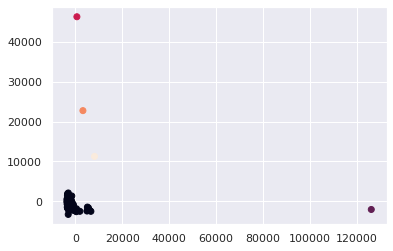

In [0]:
plt.scatter(plot_data[:,0],plot_data[:,1],c = labels)

In [0]:
name_cells_unformatted = df.T.columns.values
name_cells_unformatted

array(['Genes', 'ESC_A01', 'ESC_A02', 'ESC_A03', 'ESC_A04', 'ESC_A05',
       'ESC_A06', 'ESC_A07', 'ESC_A08', 'ESC_A09', 'ESC_A10', 'ESC_B01',
       'ESC_B02', 'ESC_B03', 'ESC_B04', 'ESC_B05', 'ESC_B06', 'ESC_B07',
       'ESC_B08', 'ESC_B09', 'ESC_B10', 'ESC_C01', 'ESC_C02', 'ESC_C03',
       'ESC_C04', 'ESC_C05', 'ESC_C06', 'ESC_C07', 'ESC_C08', 'ESC_C09',
       'ESC_C10', 'ESC_D01', 'ESC_D02', 'ESC_D03', 'ESC_D04', 'ESC_D05',
       'ESC_D06', 'ESC_D07', 'ESC_D08', 'ESC_D09', 'ESC_D10', 'ESC_E01',
       'ESC_E02', 'ESC_E03', 'ESC_E04', 'ESC_E05', 'ESC_E06', 'ESC_E07',
       'ESC_E08', 'ESC_E09', 'ESC_E10', 'ESC_F01', 'ESC_F02', 'ESC_F03',
       'ESC_F04', 'ESC_F05', 'ESC_F06', 'ESC_F07', 'ESC_F08', 'ESC_F09',
       'ESC_F10', 'ESC_G01', 'ESC_G02', 'ESC_G03', 'ESC_G04', 'ESC_G05',
       'ESC_G06', 'ESC_G07', 'ESC_G08', 'ESC_G09', 'ESC_G10', 'ESC_H01',
       'ESC_H02', 'ESC_H03', 'ESC_H04', 'ESC_H05', 'ESC_H06', 'ESC_H07',
       'ESC_H08', 'ESC_H09', 'ESC_H10'], dtype=object

In [0]:
name_cells = name_cells_unformatted[1:]
name_cells

array(['ESC_A01', 'ESC_A02', 'ESC_A03', 'ESC_A04', 'ESC_A05', 'ESC_A06',
       'ESC_A07', 'ESC_A08', 'ESC_A09', 'ESC_A10', 'ESC_B01', 'ESC_B02',
       'ESC_B03', 'ESC_B04', 'ESC_B05', 'ESC_B06', 'ESC_B07', 'ESC_B08',
       'ESC_B09', 'ESC_B10', 'ESC_C01', 'ESC_C02', 'ESC_C03', 'ESC_C04',
       'ESC_C05', 'ESC_C06', 'ESC_C07', 'ESC_C08', 'ESC_C09', 'ESC_C10',
       'ESC_D01', 'ESC_D02', 'ESC_D03', 'ESC_D04', 'ESC_D05', 'ESC_D06',
       'ESC_D07', 'ESC_D08', 'ESC_D09', 'ESC_D10', 'ESC_E01', 'ESC_E02',
       'ESC_E03', 'ESC_E04', 'ESC_E05', 'ESC_E06', 'ESC_E07', 'ESC_E08',
       'ESC_E09', 'ESC_E10', 'ESC_F01', 'ESC_F02', 'ESC_F03', 'ESC_F04',
       'ESC_F05', 'ESC_F06', 'ESC_F07', 'ESC_F08', 'ESC_F09', 'ESC_F10',
       'ESC_G01', 'ESC_G02', 'ESC_G03', 'ESC_G04', 'ESC_G05', 'ESC_G06',
       'ESC_G07', 'ESC_G08', 'ESC_G09', 'ESC_G10', 'ESC_H01', 'ESC_H02',
       'ESC_H03', 'ESC_H04', 'ESC_H05', 'ESC_H06', 'ESC_H07', 'ESC_H08',
       'ESC_H09', 'ESC_H10'], dtype=object)

In [0]:
labelled_cluster = dict(zip(name_cells, labels))

# The Final Clusters

In [0]:
i = 0
for i in range(10):
    print("Cluster " + str(i) + ":")
    for cell, cluster in labelled_cluster.items():
        if cluster == i:
            print(cell)
    i += 1

Cluster 0:
ESC_D01
Cluster 1:
ESC_A02
ESC_A04
ESC_A05
ESC_A06
ESC_A07
ESC_A08
ESC_A09
ESC_A10
ESC_B01
ESC_B02
ESC_B03
ESC_B04
ESC_B05
ESC_B06
ESC_B07
ESC_B08
ESC_B09
ESC_B10
ESC_C02
ESC_C03
ESC_C04
ESC_C05
ESC_C06
ESC_C07
ESC_C08
ESC_C09
ESC_D03
ESC_D04
ESC_D05
ESC_D06
ESC_D07
ESC_D08
ESC_D09
ESC_D10
ESC_E01
ESC_E02
ESC_E03
ESC_E04
ESC_E05
ESC_E06
ESC_E07
ESC_E08
ESC_E09
ESC_E10
ESC_F02
ESC_F03
ESC_F04
ESC_F05
ESC_F07
ESC_F08
ESC_F09
ESC_G01
ESC_G02
ESC_G03
ESC_G05
ESC_G06
ESC_G07
ESC_G08
ESC_G09
ESC_G10
ESC_H02
ESC_H03
ESC_H04
ESC_H05
ESC_H07
ESC_H08
ESC_H09
ESC_H10
Cluster 2:
ESC_C10
Cluster 3:
ESC_A01
ESC_D02
ESC_F01
ESC_H01
Cluster 4:
ESC_H06
Cluster 5:
ESC_G04
Cluster 6:
ESC_F06
Cluster 7:
ESC_C01
Cluster 8:
ESC_A03
Cluster 9:
ESC_F10
